# A simple Keplerian test case
In ths notebook we show a simple case under Keplerian mechanics.

We take the tiem to also explain step after step the corresponding equations expressing the various variations.

We start with needed imports ...

In [1]:
import numpy as np
import heyoka as hey
import time
import pickle as pkl

# Our module
import mit

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

... and set the problem data. Note that we are assuming a grid with $N$ points from $0$ to $4\pi$ and we pick three points with indexes $i,j$ and $n$. In this last point (which in this case happens to be at the very end) we apply a $\Delta V$.

In [2]:
# Problem data
n_points = 200
r0 = np.array([1., 0., 0.])
v0 = np.array([0., 1., 0.])
DVn = np.array([0.6, -0.2, 0.])
t_grid = np.linspace(0, 4*np.pi, n_points)

# DV is appliedat the end
n=n_points-1

# We will first show all developments and computations for
idx_i = 10
idx_j = 20

We now integrate the veariational equations. Fo a generic case with one impulse applied at a node $n$ we split the numerical propagation in two. From $0$ to $n$ and from $n$ to the end. This, of course, icludes the corner case where $n=f$, e.g. the impulse is applied at the very end as in our case.

In [6]:
# First we instantiate the appropriate Taylor integrator:
ta = mit.ta_kepler_variational
# Reset the start time to zero
ta.time = 0.0
# Reset the ic of the variational equation (for safety)
ic_var = np.eye(6).reshape((36,))
# Set the initial state
ta.state[:] = list(r0) + list(v0) + list(ic_var)
# Perform the propagation up to the DV
out1 = ta.propagate_grid(t_grid[:n+1])
# add the DV
ta.state[3:6] = ta.state[3:6] + DVn
# Perform the propagation from the DV t the end
out2 = ta.propagate_grid(t_grid[n:])
# Assemble the grid of STMs (avoiding to insert the point n 2 times)
out = np.vstack((out1[-1], out2[-1][1:]))

# These are M0i from the initial to the i-th time grid point.
stms_0i = [out[i,6:].reshape(6,6) for i in range(len(t_grid))]
# These are Mif from the i-th time grid point to the end
M0f = stms_0i[-1]
stms_if = [M0f@np.linalg.inv(stms_0i[i]) for i in range(len(t_grid))]
Mfn = np.linalg.inv(stms_if[n])


The above quantites are all that is needed for the computation of the relevant primer condition for a specific $i,j$. Let us follow the derivation and produce them for a generic case (i.e. any $i,j,n$ in the grid).

We start from the equation defining the dynamic constraints which can be written as:

$$
\delta \mathbf x_f = \mathbf M_{if} \delta \mathbf x_i + \mathbf M_{nf} \delta\mathbf x_n + \mathbf M_{jf} \delta\mathbf x_j = \mathbf 0
$$

... which we premultiply by $\mathbf M_{fn}$ as to obtain:

$$
\mathbf M_{i} \delta\mathbf x_i + \mathbf M_{j} \delta\mathbf x_j + \delta\mathbf x_n = \mathbf 0
$$

In [7]:
# For any given choice of the three indexes we need the matrices:
Mif = stms_if[idx_i]
Mjf = stms_if[idx_j]
# We now premultiply by Mfn as to simplify the constraint equation
Mi = Mfn@Mif
Mj = Mfn@Mjf

... which we can write explicitly reporting the position and velocity equations as:

$$
\begin{align}
\delta\mathbf r_f &=& \mathbf M_i^{rv} \delta\Delta \mathbf V_i + \mathbf M_j^{rv} \delta\Delta \mathbf V_j = \mathbf 0\\
\delta\mathbf v_f &=& \mathbf M_i^{vv} \delta\Delta \mathbf V_i + \mathbf M_j^{vv} \delta\Delta \mathbf V_j + \delta\Delta \mathbf V_n = \mathbf 0\\
\end{align}
$$

which can be solved into:

$$
\begin{align}
\delta\Delta \mathbf V_i &=& - (\mathbf M_i^{rv})^{-1}\mathbf M_j^{rv} \delta\Delta \mathbf V_j := \mathbf A_{ij}\delta\Delta \mathbf V_j\\
\delta\Delta \mathbf V_n &=& - \big(\mathbf M_i^{vv}\mathbf A_{ij} + \mathbf M_j^{vv} \big)  \delta\Delta \mathbf V_j := \mathbf A_{nj}\delta\Delta \mathbf V_j\\
\end{align}
$$

In [8]:
Mrvj = Mj[:3,3:]
Mrvi = Mi[:3,3:]
Mrvi_inv = np.linalg.inv(Mrvi)
Mvvj = Mj[3:,3:]
Mvvi = Mi[3:,3:]
Aij = - Mrvi_inv@Mrvj
Anj = - (Mvvi@Aij+Mvvj)

We now consider the variation of the total $\Delta v$ which incurs when adding the three infinitesimal impulses (two of which correspond to new ones, one applied to an already existing one and thus able to decrease its magnitude):

$$
\delta \Delta v = J = |\delta\Delta \mathbf V_i| + |\delta\Delta \mathbf V_j| + \frac{\Delta \mathbf V_n}{|\Delta \mathbf V_n|}\cdot \delta\Delta \mathbf V_n
$$

which we can develop into:

$$
\delta \Delta v = J = |\mathbf A_{ij}\delta\Delta \mathbf V_j| + |\delta\Delta \mathbf V_j|  + \frac{\Delta \mathbf V_n}{|\Delta \mathbf V_n|}\cdot \mathbf A_{nj}\delta\Delta \mathbf V_j
$$

and eventually write as:

$$
J = \big(1 + |\mathbf A_{ij} \hat{\mathbf u}_j| + \frac{\Delta \mathbf V_n}{|\Delta \mathbf V_n|}\cdot \mathbf A_{nj}\hat{\mathbf u}_j\big)|\delta \Delta \mathbf V_j| = (1 + |\mathbf B \hat{\mathbf u}_j| - \mathbf b\cdot \hat{\mathbf u}_j )|\delta \Delta \mathbf V_j| 
$$


In [9]:
B = Aij
b =  - DVn@Anj / np.linalg.norm(DVn)

... and we minimize

$$
\min_{|\hat{\mathbf u}|=1} \big(|\mathbf B \hat{\mathbf u}_i| - \mathbf b\cdot\hat{\mathbf u}_i\big) < -1
$$

using two very different methods (we should get the same results here)

In [10]:
# scipy solver using the stereographic coordinates as decision vector
a1,a2 = mit.minBu_bu(B, b)
print(a1, a2)

0.4444059620904808 [0 0 0]


In [11]:
# pygmo solver with a more "direct: encoding"
a1,a2 = mit.minBu_bu_p(B, b)
print(a1, a2)


0.4444059620904808 [0 0 0]


Let us put all into a for loop and compute the surrogate vector map for all ossible $i$ and $j$.


In [12]:
p = np.ones((n_points,n_points))
for idx_i in range(n_points):
    if idx_i==n:
            continue
    for idx_j in range(idx_i+1,n_points):
        if idx_j==n:
            continue
        Mif = stms_if[idx_i]
        Mjf = stms_if[idx_j]
        # We now premultiply by Mfn as to simplify the constraint equation
        Mi = Mfn@Mif
        Mj = Mfn@Mjf
        # And compute the Aij
        Mrvj = Mj[:3,3:]
        Mrvi = Mi[:3,3:]
        Mrvi_inv = np.linalg.inv(Mrvi)
        Mvvj = Mj[3:,3:]
        Mvvi = Mi[3:,3:]
        Aij = - Mrvi_inv@Mrvj
        Anj = - (Mvvi@Aij+Mvvj)
        # And B, b
        B = Aij
        b = - DVn@Anj / np.linalg.norm(DVn)
        # and solve
        a,sol = mit.minBu_bu_p(B, b)
        p[idx_i, idx_j] = np.inf
        p[idx_j, idx_i] = a


In [13]:
idx1, idx2 = np.unravel_index(p.argmin(), p.shape)
print(t_grid[idx1], t_grid[idx2])
print(np.min(p))
p_clean=p.copy()
p_clean=-p_clean

7.7671536963124534 4.736069327019789
-2.754489165215877


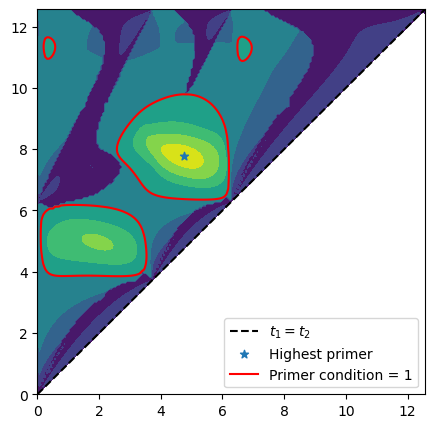

In [14]:
fig = plt.figure(figsize=(5,5))
X,Y = np.meshgrid(t_grid, t_grid)
plt.contourf(X,Y,p_clean)
plt.contour(X,Y,p_clean, [1], colors='r', linestyles='solid')
plt.savefig("surrogate_primer_halo.png", dpi=600)
plt.plot(t_grid,t_grid, 'k--', label="$t_1=t_2$")
plt.scatter(t_grid[idx2], t_grid[idx1], label="Highest primer", marker="*")
plt.plot([],[], 'r', label="Primer condition = 1")
plt.legend(loc="lower right")

plt.savefig("hetero_transfer_s.png", dpi=600)